In [85]:
import joblib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point

In [ ]:
# Configurações do Estado da Paraíba
gdf = gpd.read_file('../datas/external/brazil-states.geojson', encoding='utf-8')
estado_gdf = gdf[gdf['name'] == 'Paraíba']

## Mapa de Precipitação Mensal Anual Acumulada (Dados Locais)

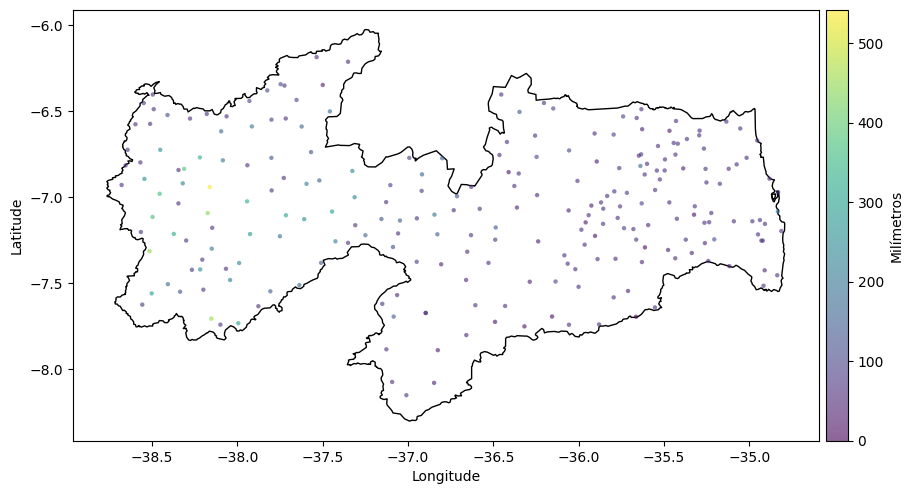

In [74]:
# Carregar os dados
df_aesa_sum = pd.read_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_sum.csv")
df_aesa_sum = df_aesa_sum[(df_aesa_sum['ano'] == 1994) & (df_aesa_sum['mes'] == 1)]

# Criar a figura
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o mapa base do estado
estado_gdf.plot(ax=ax, color='white', edgecolor='black')

# Plotar os dados preditos como uma imagem
scatter = ax.scatter(df_aesa_sum['lon'], df_aesa_sum['lat'], c=df_aesa_sum['pr_local'], cmap='viridis', alpha=0.6, s=10, edgecolors='none')

# Adicionar uma barra de cores
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.01, fraction=0.0278)
cbar.set_label('Milímetros')

# Adicionar títulos e rótulos
# plt.title('Mapa de Precipitação Mensal Anual Acumulada')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar o mapa
plt.show()

## Mapa de Precipitação Mensal Anual Acumulada (Dados CMIP6)

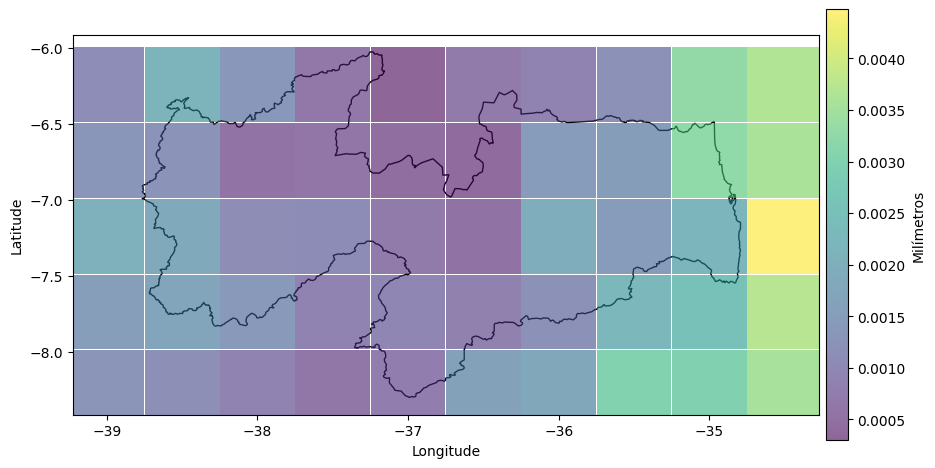

In [77]:
# Carregar os dados
df_cmip6_sum = pd.read_csv('../datas/interim/1.3.2_cmip6_database_create/pr_day_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_19940101-21001231_sum.csv')
df_cmip6_sum['lon'] = df_cmip6_sum['lon'] - 360
df_cmip6_sum = df_cmip6_sum[(df_cmip6_sum['ano'] == 1994) & (df_cmip6_sum['mes'] == 1)]

# Criar a figura
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o mapa base do estado
estado_gdf.plot(ax=ax, color='white', edgecolor='black')

# Plotar os dados preditos como uma imagem
scatter = ax.scatter(df_cmip6_sum['lon'], df_cmip6_sum['lat'], c=df_cmip6_sum['pr'], cmap='viridis', alpha=0.6, s=2900, marker='s', edgecolors='none')

# Adicionar uma barra de cores
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.01, fraction=0.0278)
cbar.set_label('Milímetros')

# Adicionar títulos e rótulos
# plt.title('Mapa de Precipitação Mensal Anual Acumulada')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar o mapa
plt.show()

## Mapa de Precipitação Mensal Anual Acumulada (Dados de Redução de Escala)

In [133]:
# Recuperando modelo
model = joblib.load("../models/aesa_to_cnrm_cm6_1hr_sum_downscaling_database.joblib")

# Definir os limites da área de contorno
contorno = estado_gdf.geometry.iloc[0]
x_min, y_min, x_max, y_max = contorno.bounds

# Criar uma lista para armazenar os pontos dentro do contorno
pontos_dentro_contorno = []

# Definir a quantidade de pontos na grade
num_points = 200  # Aumente este número para uma grade mais fina

# Gerar os pontos dentro da área de contorno
for i in range(num_points):
    for j in range(num_points):
        x = x_min + i * (x_max - x_min) / (num_points - 1)
        y = y_min + j * (y_max - y_min) / (num_points - 1)
        point = Point(x, y)
        if contorno.contains(point):
            pontos_dentro_contorno.append((x, y))

# Criando DataFrame
latlon = []

for i in range(len(pontos_dentro_contorno)):
    for j in range(1, 13):
        for k in range(1994, 1995):
            latlon.append({'lat': pontos_dentro_contorno[i][1],
                           'lon': pontos_dentro_contorno[i][0],
                           'ano': k,
                           'mes': j})


df_esp = pd.DataFrame(latlon)

df_esp = df_esp[model.feature_names_in_]

df_esp['pr'] = model.predict(df_esp)

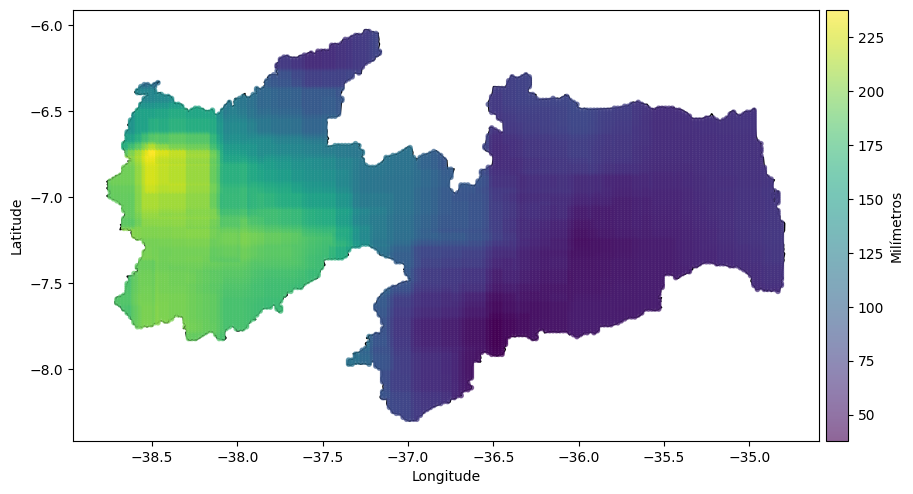

In [134]:
df_esp_ = df_esp[df_esp['mes'] == 1]

# Criar a figura
fig, ax = plt.subplots(figsize=(10, 10))

# Plotar o mapa base do estado
estado_gdf.plot(ax=ax, color='white', edgecolor='black')

# Plotar os dados preditos como uma imagem
scatter = ax.scatter(df_esp_['lon'], df_esp_['lat'], c=df_esp_['pr'], cmap='viridis', alpha=0.6, s=10)

# Adicionar uma barra de cores
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.01, fraction=0.0278)
cbar.set_label('Milímetros')

# Adicionar títulos e rótulos
# plt.title('Mapa de Precipitação Mensal Anual Acumulada')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Mostrar o mapa
plt.show()